In [1]:
cd /notebooks/

/notebooks


In [2]:
from fastai import *
from fastai.text import *   # Quick accesss to NLP functionality

import torch.utils.data as data_utils
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import Sampler
from torch.autograd import Variable

import time
import importlib
import pixiedust
import spacy

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table USER_PREFERENCES created successfully
Table service_connections created successfully


In [3]:
DATAPATH = Path('/data/WS/')
PATH = Path('/data/sav/WS/')

In [26]:
spacy_tok = spacy.load('en')

In [6]:
#DOWNLOAD THE DATA
#!aws s3 cp --recursive s3://dbressbuck/data/WS /data/WS

download: s3://dbressbuck/data/WS/evaluate.csv to ../../data/WS/evaluate.csv
download: s3://dbressbuck/data/WS/train.csv to ../../data/WS/train.csv
download: s3://dbressbuck/data/WS/sent140_training.csv to ../../data/WS/sent140_training.csv


# Preprocess the data

In [120]:
#load data, look at size of training set and test set, look at some samples
df_trn = pd.read_csv(DATAPATH/'train.csv')
df_test = pd.read_csv(DATAPATH/'evaluate.csv')
df_trn= df_trn[['sentiment','content']]
df_test= df_test[['sentiment','content']]
print(np.shape(df_trn))
print(np.shape(df_test))
print(df_trn.head())

(160000, 2)
(69594, 2)
  sentiment                                            content
0  negative  RT @evixy_: @havocharb 🙄 ALL RIGHT SHERLOCK. E...
1   neutral  @Honeybeemtb @80sbuttplug @CNN @zbyronwolf So ...
2   neutral  #Beer. #Grub. #StadiumSeating.  Best place in ...
3  positive  I want thissssssssss 😍😍😍😍😍 u have a perfect pl...
4   neutral  youtu.be/D2IHY4eRdAs IF YOU DRINK DIET SODA OR...


In [121]:
#there are some duplicate tweets... Take a quick look at them
print(np.shape(df_trn[~df_trn['content'].duplicated()]))
df_duplicated=df_trn[df_trn['content'].duplicated()]
df_duplicated.head()

(152319, 2)


,sentiment,content
1723,positive,My #McM #mancrushmonday goes out to these love...
2265,positive,#HappyHolidays from our family to yours! Wishi...
3500,positive,RT @kted_kiki: my ideal life is traveling the ...
3533,negative,Eat Shit， Brady. #SuperBowl
3534,positive,RT @thewannabegypsy: The best restaurants in #...


In [122]:
#remove duplicates... no reason to include these in training
df_trn=df_trn[~df_trn['content'].duplicated()]
print(np.shape(df_trn))

(152319, 2)


In [123]:
#check to see if there's any duplicates between train and test set... that would be cheating!
#then remove them
listA=list(df_trn['content'])
listB=list(df_test['content'])
common_elements=list(set(listA).intersection(set(listB)))
print(np.shape(common_elements))#there are a few duplicates
print(common_elements)

#remove the duplicates from the training set
print(np.shape(df_trn))
for i in range(len(common_elements)):
    df_trn=df_trn.drop(df_trn[df_trn['content']==common_elements[i]].index)
df_trn=df_trn.reset_index(drop=True)
print(np.shape(df_trn))

(7,)
['The hilarious Flash went out to the supermarket to drink some football but felt uncertain as he was flying in the wrong direction.', '@channelislam @channelislam @chahould be done at hotel buffets as well.Its disgusting how people pile plates and eat a quarter.Rest is thrown 🖓', 'There is nothing better than watching the #football game with your favorite food! Pick up #wings， #pizza， or whatever else you are craving to have when you watch the game tonight. #NFL #Vikings pic.twitter.com/NHoQtQFwuB', "New post (Game of Thrones， That's What I Do I Drink and I Know Things， Stemless Wine ...) has been published on  - happy-fathers-day.info/game-of-throne… pic.twitter.com/NlzlZT8pZP", "My parents think I'm studying hard and packing the house up but really I've just been eating junk food and watching Netflix 👩🏻\u200d💻", 'YO FUCK PRESEASON FOOTBALL!!! Ya girl was just trynna eat some ice cream and watch bachelor in paradise 😤', '*whispers*I LOVE WATCHING THE WILD EAT SHIT IN THE PLAYOFF

  sentiment                                            content  str_len
0  negative  RT @evixy_: @havocharb 🙄 ALL RIGHT SHERLOCK. E...       53
1   neutral  @Honeybeemtb @80sbuttplug @CNN @zbyronwolf So ...      221
2   neutral  #Beer. #Grub. #StadiumSeating.  Best place in ...      122
3  positive  I want thissssssssss 😍😍😍😍😍 u have a perfect pl...      253
4   neutral  youtu.be/D2IHY4eRdAs IF YOU DRINK DIET SODA OR...       91


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b34d04dd8>]], dtype=object)

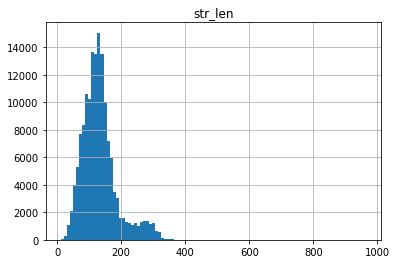

In [124]:
#create column to take a look at length of tweets, and create graph of distribution
df_trn['str_len']=df_trn['content'].str.len()
print(df_trn.head())
df_trn.hist(column='str_len', bins=100)

['negative' 'neutral' 'positive']


(array([35118.,     0.,     0.,     0.,     0., 70590.,     0.,     0.,     0., 46611.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

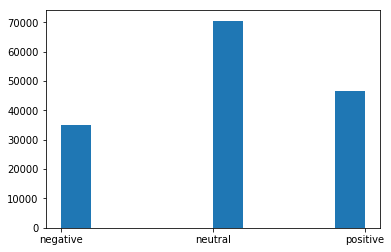

In [99]:
#look at distribution of labels
print(df_trn['sentiment'].unique()) #unique labels
plt.hist(list(df_trn['sentiment']))

(array([10477.,     0.,     0.,     0.,     0., 55766.,     0.,     0.,     0.,  3351.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

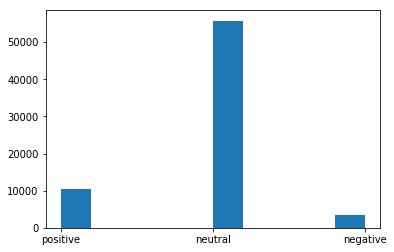

In [119]:
#Look at distribution of test dataset as well
#Huge class imbalance!
plt.hist(list(df_test['sentiment']))

# Build and run 1) language model, 2) classification model

In [125]:
df_trn.to_csv(DATAPATH/'train_proc.csv', index=False)
df_test.to_csv(DATAPATH/'test_proc.csv', index=False)

In [126]:
print(df_trn.head())

  sentiment                                            content  str_len
0  negative  RT @evixy_: @havocharb 🙄 ALL RIGHT SHERLOCK. E...       53
1   neutral  @Honeybeemtb @80sbuttplug @CNN @zbyronwolf So ...      221
2   neutral  #Beer. #Grub. #StadiumSeating.  Best place in ...      122
3  positive  I want thissssssssss 😍😍😍😍😍 u have a perfect pl...      253
4   neutral  youtu.be/D2IHY4eRdAs IF YOU DRINK DIET SODA OR...       91


In [127]:
print(df_test.head())

  sentiment                                            content
0  positive  @joselynalghul I mean you GOTTA go to Grand Ce...
1   neutral  ** HAPPY COOKING **#MAINCUISINE #COOKING #RECI...
2   neutral  RT @RiverRatBrewery: Today is the day! It's Su...
3   neutral  I ate chili cheese fries at 1AM and watched 13...
4   neutral  The Most Popular Super Bowl Recipes in Every S...


In [154]:
#set momentum values
moms = (0.8,0.7)

In [128]:
#language model data object
data_lm = TextLMDataBunch.from_csv(DATAPATH, 'train_proc.csv')

In [131]:
#This is using fast.ai's pretrained language model:
#Model pretrained on wikitext103 dataset: 
    #https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/
    #~100M tokens, ~270K vocab
#Model based on Merity/Socher's AWD-LSTM quasi-recurrent neural network (QRNN)
    #https://arxiv.org/abs/1708.02182
learn = language_model_learner(data_lm, AWD_LSTM)
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-2), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,4.081447,3.728842,0.360819,03:04
1,3.756207,3.460654,0.391099,03:06
2,3.557852,3.351406,0.404250,03:07
3,3.432202,3.328161,0.407641,03:07


In [132]:
#save weights from language model
learn.save_encoder('enc')

In [153]:
#create dataset for classification model
data_clas2 = TextClasDataBunch.from_csv(DATAPATH, 'train_proc.csv', 
            test='test_proc.csv', vocab=data_lm.train_ds.vocab, bs=40)

In [155]:
#Classification model based on Howard/Ruder's ULMFiT approach:
    #https://arxiv.org/abs/1801.06146
#Start with pretrained LM and fine-tune on dataset as above
#Keep the LM's "encoder" spine, but replace the head of the NN with a new network that predicts class
#This approach utilizes transfer learning to enhance the classifier's performance
#Also using one_cycle superconvergence: modify the learning rate and momentum value during training
    #Ramp up then down the LR, while ramping down then up the momentum
    #Significantly reduces training time and improves performance
    #From Leslie Smith's paper: https://arxiv.org/pdf/1803.09820.pdf

learn2 = text_classifier_learner(data_clas2, AWD_LSTM)
learn2.load_encoder('enc')#load in the weights from the LM encoder
learn2.fit_one_cycle(4, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.873037,0.769597,0.648623,01:45
1,0.841288,0.739303,0.668582,01:44
2,0.838200,0.722005,0.683780,01:43
3,0.812155,0.717243,0.684732,01:46


In [156]:
#Unfreeze all the layers and continue training:
#Above, all the layers except for the last layer is frozen
    #Idea is that "encoder" spine from the LM is fairly well-tuned, so only need to train the classifier head
#Once head has been trained, now we can train all the layers of the network
learn2.unfreeze()
learn2.fit_one_cycle(8, slice(1e-5,1e-3), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.800146,0.684788,0.703411,04:20
1,0.736613,0.593232,0.754588,04:23
2,0.671252,0.503970,0.804090,04:07
3,0.584129,0.447479,0.831730,04:13
4,0.538299,0.419107,0.846273,04:12
5,0.528030,0.387832,0.858189,04:24
6,0.512136,0.386526,0.858254,04:24
7,0.528796,0.381221,0.860224,04:23


In [163]:
#save weights from classifier model
learn2.save_encoder('classifier_weights_001')

In [161]:
#The AWD-LSTM model backbone, with a linear classifier head
learn2.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(46365, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(46365, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.4)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=

# Get predictions on test set

In [157]:
test_predictions=learn2.get_preds('Test')

In [158]:
accuracy(*test_predictions)

tensor(0.8632)